<a href="https://colab.research.google.com/github/sdbrgo/PERCEUL/blob/main/PERCEUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
!pip install hdbscan

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import json

# pipeline
from sklearn.pipeline import Pipeline

# preprocesing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin # used to define NumericSelector(), which is used in preprocessing

# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# cluster validation
from sklearn.metrics import silhouette_score

# clustering
from sklearn.cluster import KMeans
import hdbscan

# Mount GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dataset

In [ ]:
ds_name = "/content/drive/MyDrive/Datasets/perceul-data-tactics.csv"
df = pd.read_csv(ds_name)

# Preprocessing

In [ ]:
#=====================================================================
# a custom and dynamic function for selecting numeric columns only.
# will be used to make the pipeline
class NumericSelector(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        self.numeric_cols_ = X.select_dtypes(include=[float, int]).columns
        return self

    def transform(self, X):
        X_num = X[self.numeric_cols_]
        return X_num
#=====================================================================

si = SimpleImputer(strategy='median')
df_i = si.fit_transform(df)
df_i = pd.DataFrame(df_i, columns=df.columns)

ss = StandardScaler()
df_i_ss = ss.fit_transform(df_i)
df_p1 = pd.DataFrame(df_i_ss, columns=df.columns) # will undergo cluster exploration
df_p2 = df_p1.copy() # will undergo final clustering

# Dimensionality Reduction 1

In [ ]:
tsne = TSNE(
    n_components=2, # default
    perplexity=2,
    learning_rate='auto', # default
    init='pca', # default
    random_state=42
)
df_tsne = tsne.fit_transform(df_p1)

# Cluster Exploration


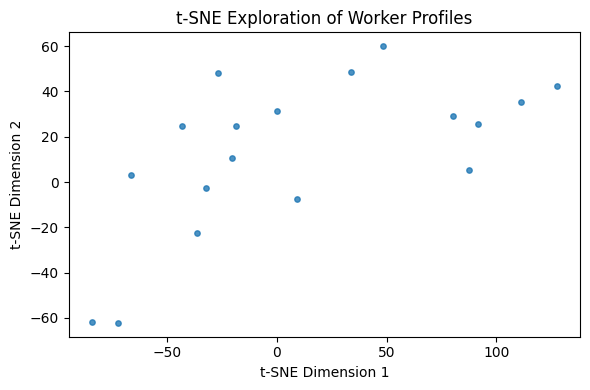

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=15, alpha=0.8)
plt.title("t-SNE Exploration of Worker Profiles")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.tight_layout()
plt.show()

# Dimensionality Reduction 2

In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_p2)

# Final Clustering

Executing choose_k()... Best Score: 0.4742832357715656 | Best K: 4


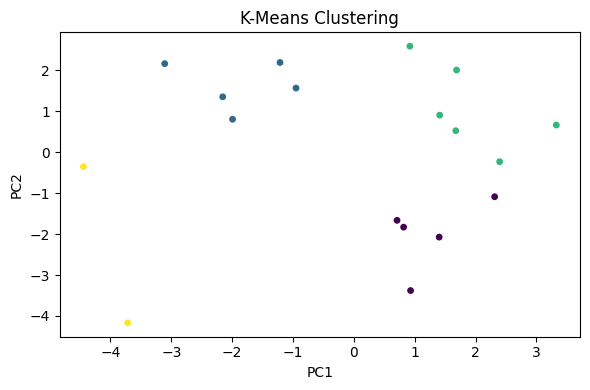

In [ ]:
#============================================================
# function to identify the best `k` value.
# put this inside `cluster_utils.py`
def choose_k(X_pca, k_range=(2, 12)):
    best_k = 2
    best_score = -1

    # Ensure k does not exceed n_samples - 1 for silhouette_score validity
    n_samples = X_pca.shape[0]
    max_k_for_silhouette = n_samples # range is exclusive of end, so this will allow k up to n_samples - 1

    for k in range(k_range[0], min(k_range[1], max_k_for_silhouette)):
        km = KMeans(n_clusters=k, random_state=42, n_init='auto') # Added n_init='auto' to suppress future warning
        labels = km.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)

        if score > best_score:
            best_score = score
            best_k = k

    print(f"Executing choose_k()... Best Score: {best_score} | Best K: {best_k}")

    return best_k
#============================================================

best_k = choose_k(df_pca) # pre-defined function

km_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto') # Added n_init='auto'
labels = km_final.fit_predict(df_pca)

plt.figure(figsize=(6, 4))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, s=15)
plt.title('K-Means Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()


# Cluster Analysis

In [ ]:
#============================================================
# place these functions in `cluster_utils.py` file
def compute_cluster_centroids_pca(df_pca, labels):
    df = pd.DataFrame(df_pca)
    df['cluster'] = labels

    return df.groupby('cluster').mean()

# maps PCA-space centroids back to original feature space
def inverse_project_centroids(pca_centroids, pca_model, scaler_model, original_feature_names):

    # back-project from PCA space to scaled feature space
    scaled_centroids = pca_model.inverse_transform(pca_centroids.values)

    # undo scaling
    original_space_centroids = scaler_model.inverse_transform(scaled_centroids)

    df_original = pd.DataFrame(
        original_space_centroids,
        columns=original_feature_names,
        index=pca_centroids.index
    )

    return df_original

def compute_cluster_stats(df_pca, labels, feature_names):
    df = pd.DataFrame(df_pca, columns=feature_names)
    df['cluster'] = labels

    stats = {}

    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id].drop(columns=['cluster'])

        stats[cluster_id] = {
            "count": len(cluster_data),
            "mean": cluster_data.mean().to_dict(),
            "median": cluster_data.median().to_dict(),
            "std": cluster_data.std().to_dict(),
            "min": cluster_data.min().to_dict(),
            "max": cluster_data.max().to_dict(),
            "range": (cluster_data.max() - cluster_data.min()).to_dict()
        }

    return stats

# ranks top drivers based on `top_n`
def identify_top_drivers(original_space_centroids, top_n):
    global_mean = original_space_centroids.mean()

    drivers = {}

    for cluster_id, row in original_space_centroids.iterrows():
        deviation = row - global_mean
        ranked = deviation.abs().sort_values(ascending=False)

        top_features = ranked.head(top_n).index.tolist()

        drivers[cluster_id] = {
            "top_features": top_features,
            "deviations": deviation[top_features].to_dict()
        }

    return drivers
#============================================================

# Correcting to use df_pca for centroid and stats calculations in PCA space
feature_names_pca = [f'PC{i+1}' for i in range(df_pca.shape[1])]
cluster_stats = compute_cluster_stats(df_pca, labels, feature_names_pca)

original_feature_names = df.columns.tolist() # original feature names BEFORE scaling/PCA
pca_centroids = compute_cluster_centroids_pca(df_pca, labels) # compute cluster centroids in PCA space (using pca-fitted df)
original_centroids = inverse_project_centroids(
    pca_centroids,
    pca, # Use the global PCA() instance
    ss, # Use the global StandardScaler() instance
    original_feature_names
)
top_drivers = identify_top_drivers(original_centroids, top_n=7) # rank original feature drivers per cluster

# display results
for cluster_id in cluster_stats.keys():
    print(f"Cluster {cluster_id} Summary")

    print("\nTop Feature Drivers (Original Space):")
    for feature, value in top_drivers[cluster_id]['deviations'].items():
        print(f"  {feature}: {value:.3f}")

    # print("\nStatistics (PCA space):")
    # print(json.dumps(cluster_stats[cluster_id], indent=4))

    print("\n---\n")

Cluster 0 Summary

Top Feature Drivers (Original Space):
  Speech Intelligibility Issues: 1.641
  Odor Distractibility: 1.554
  Environmental Distractability: 1.272
  Perceived Mental Demand: 1.130
  Error Likelihood: 1.104
  Lighting Adequacy: 1.001
  Perceived Task Complexity: 0.791

---

Cluster 1 Summary

Top Feature Drivers (Original Space):
  Odor Distractibility: -1.451
  Speech Intelligibility Issues: -1.320
  Error Likelihood: -1.256
  Environmental Distractability: -1.138
  Perceived Mental Demand: -0.958
  Perceived Task Complexity: -0.907
  Odor Pleasantness: 0.839

---

Cluster 2 Summary

Top Feature Drivers (Original Space):
  Airflow Satisfaction: 1.694
  Temperature Satisfaction: 1.581
  Coordination Satisfaction: 1.490
  Lighting Adequacy: 1.313
  Organizational Support: 1.230
  Perceived Communication Efficiency: 1.117
  Frequency of Interruptions: 1.066

---

Cluster 3 Summary

Top Feature Drivers (Original Space):
  Airflow Satisfaction: -2.180
  Temperature Satisfa

# Creating the PERCEUL Pipeline

In [ ]:
# pipeline for Cluster Exploration
exploration_pipeline = Pipeline(steps = [
    ('numeric_selector', NumericSelector()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# pipeline for Final Clustering (Production)
core_pipeline = Pipeline(steps = [
    ('numeric_selector', NumericSelector()),
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42))
])

# Saving the Pipeline

In [ ]:
joblib.dump(exploration_pipeline, 'exploration_pipeline.pkl')
# joblib.dump(core_pipeline, 'core_pipeline.pkl')

['exploration_pipeline.pkl']